In [342]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from torch import nn
import torchvision.transforms as T
from collections import defaultdict
import matplotlib.pyplot as plt

In [343]:
df = pd.read_csv('groups.csv')

In [344]:
print(max(df['Labels']))

99.0


In [345]:
train_images = torch.load('train_images.pt')
train_labels = torch.load('train_labels.pt')
test_images = torch.load('test_images.pt')
test_labels = torch.load('test_labels.pt')

/var/folders/bn/hglmht2s7y19n14x7s3vfm2m0000gn/T/ipykernel_99744/1655403495.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_images = torch.load('train_images.pt')


Define a Dataset class that take in the image, the label, and what subcluster group it belongs to

In [346]:
class GroupData(Dataset):
    def __init__(self,images, labels, groups):
        self.image = images
        self.label = labels
        self.group = groups

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, index):
        return self.image[index], self.label[index], self.group[index]

Create a weighted random sampler to ensure that all groups are equally included in a batch

In [347]:
class_counts = df.value_counts()
sample_weights = [1/class_counts[i] for i in df['Labels']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

Create the dataloaders. The batch size is 64

In [348]:
train_data = GroupData(train_images, train_labels, df['Labels'])
train_dataloader = DataLoader(train_data,sampler = sampler, batch_size=64)
test_data = TensorDataset(test_images, test_labels)
test_dataloader = DataLoader(test_data, 5)

Redefine the model architecture

In [349]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            nn.Conv2d(3,9,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(9,18,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(1,-1),
            nn.Linear(288,64)
            )
        self.relu = nn.ReLU()
        self.l = nn.Linear(64,5)

    def forward(self, x):
        x = self.net(x)
        x = self.relu(x)
        return self.l(x)

Train the model. We use a learning rate of 0.00005, and train for 150 epochs. We have 2 loss functions because one is used for training and the other is used for testing. We don't reduce the values from the loss function because we want to know the loss of each individual value so we can record it and find the worst group. We don't use a learning rate reducer due to the volatility of the testing loss(visualized below)

In [350]:
model = LeNet()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss(reduction='none')
loss_fn2 = nn.CrossEntropyLoss()
transform = T.Compose([
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])
test_loss = []
epochs = 150
best_loss = 100
for epoch in range(epochs):
    group_losses = defaultdict(float)
    group_num = defaultdict(int)
    model.train()
    for x,y,groups in train_dataloader:
        x = transform(x)
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        for group in groups.unique():
            group_mask = (groups == group)
            group_losses[group.item()] += loss[group_mask.squeeze()].mean().item()
            group_num[group.item()] += len(loss[group_mask.squeeze()])
        
        worst_group = max(group_losses, key = lambda g: group_losses[g] / group_num[g])
        loss[groups == worst_group].mean().backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        tot_loss = 0
        for x,y in test_dataloader:
            x = transform(x)
            y_pred = model(x)
            loss = loss_fn2(y_pred, y)
            tot_loss += loss.item()
        tot_loss /= len(test_dataloader)
        test_loss.append(tot_loss)
    if(tot_loss < best_loss):
        torch.save(model.state_dict(),'model2.pt')
        best_loss = tot_loss

    print(f"Epoch {epoch+1}: {test_loss[-1]:.4f}")

Epoch 1: 1.6448
Epoch 2: 1.6450
Epoch 3: 1.6086
Epoch 4: 1.6210
Epoch 5: 1.6051
Epoch 6: 1.6156
Epoch 7: 1.6150
Epoch 8: 1.6542
Epoch 9: 1.5899
Epoch 10: 1.5872
Epoch 11: 1.5661
Epoch 12: 1.5349
Epoch 13: 1.4330
Epoch 14: 1.3988
Epoch 15: 1.3419
Epoch 16: 1.2603
Epoch 17: 1.2747
Epoch 18: 1.1967
Epoch 19: 1.2213
Epoch 20: 1.1234
Epoch 21: 1.2278
Epoch 22: 1.0342
Epoch 23: 1.0232
Epoch 24: 0.8652
Epoch 25: 1.0834
Epoch 26: 0.9985
Epoch 27: 0.9311
Epoch 28: 0.8557
Epoch 29: 0.8309
Epoch 30: 0.8967
Epoch 31: 0.9210
Epoch 32: 0.8433
Epoch 33: 0.8987
Epoch 34: 0.7932
Epoch 35: 0.8199
Epoch 36: 0.8372
Epoch 37: 0.8784
Epoch 38: 0.8689
Epoch 39: 0.7850
Epoch 40: 0.7632
Epoch 41: 0.7791
Epoch 42: 0.7486
Epoch 43: 0.7731
Epoch 44: 0.7538
Epoch 45: 0.8849
Epoch 46: 0.8106
Epoch 47: 0.8109
Epoch 48: 0.7682
Epoch 49: 0.8224
Epoch 50: 0.9256
Epoch 51: 0.8579
Epoch 52: 0.8195
Epoch 53: 0.7811
Epoch 54: 0.7054
Epoch 55: 0.7566
Epoch 56: 0.8726
Epoch 57: 0.8522
Epoch 58: 0.8948
Epoch 59: 0.8755
Epoch 

Visualize the loss over each epoch

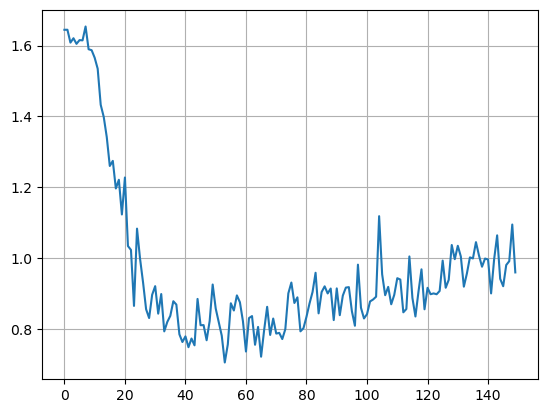

In [355]:
plt.plot(test_loss)
plt.grid(True)

In [357]:
num_correct = 0
model.eval()
model.load_state_dict(torch.load("model2.pt", weights_only=True))
with torch.no_grad():
    for x,y in test_dataloader:
        y_pred = model(transform(x))
        num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
print(f"Accuracy: {100 * num_correct/(len(test_dataloader)*5):.2f}%")

Accuracy: 74.90%
